In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tabulate as tb
import seaborn as sns

In [2]:
df = pd.read_csv('./../res/model1_testing_1.csv')
print(tb.tabulate(df.tail(), headers='keys', tablefmt='psql'))  

+-----+------------------------+---------------------+-------------------------------------------------------------------------------------------------------------------+--------------+----------------------------+------------+------------+-------------+----------+-----------+----------------------+------------------+
|     | file_path              |   feature_set_index | features                                                                                                          |   repetition | first_prediction_correct   |   accuracy |   f1_score |   precision |   recall |   auc_roc | confusion_matrix     |   last epoch num |
|-----+------------------------+---------------------+-------------------------------------------------------------------------------------------------------------------+--------------+----------------------------+------------+------------+-------------+----------+-----------+----------------------+------------------|
| 655 | ./../data/^GSPC_1h.csv |        

In [3]:
def calc_precision_recall_ba(row):
    confusion_matrix = np.array(eval(row['confusion_matrix']))
    tn, fp, fn, tp = confusion_matrix.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0 
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    ba = (recall + tnr) / 2
    return precision, recall, ba

df['precision'] = 0.0
df['recall'] = 0.0
df['balanced_accuracy'] = 0.0
for index, row in df.iterrows():
    precision, recall, ba = calc_precision_recall_ba(row)
    df.at[index, 'precision'] = precision
    df.at[index, 'recall'] = recall
    df.at[index, 'balanced_accuracy'] = ba
    
print(tb.tabulate(df.head(), headers='keys', tablefmt='psql'))
    

+----+-----------------------+---------------------+---------------------------------------------------------------+--------------+----------------------------+------------+------------+-------------+----------+-----------+------------------------+------------------+---------------------+
|    | file_path             |   feature_set_index | features                                                      |   repetition | first_prediction_correct   |   accuracy |   f1_score |   precision |   recall |   auc_roc | confusion_matrix       |   last epoch num |   balanced_accuracy |
|----+-----------------------+---------------------+---------------------------------------------------------------+--------------+----------------------------+------------+------------+-------------+----------+-----------+------------------------+------------------+---------------------|
|  0 | ./../data/AAPL_1h.csv |                   0 | ['Close']                                                     |            0 

# ACCURACY PER INDEX

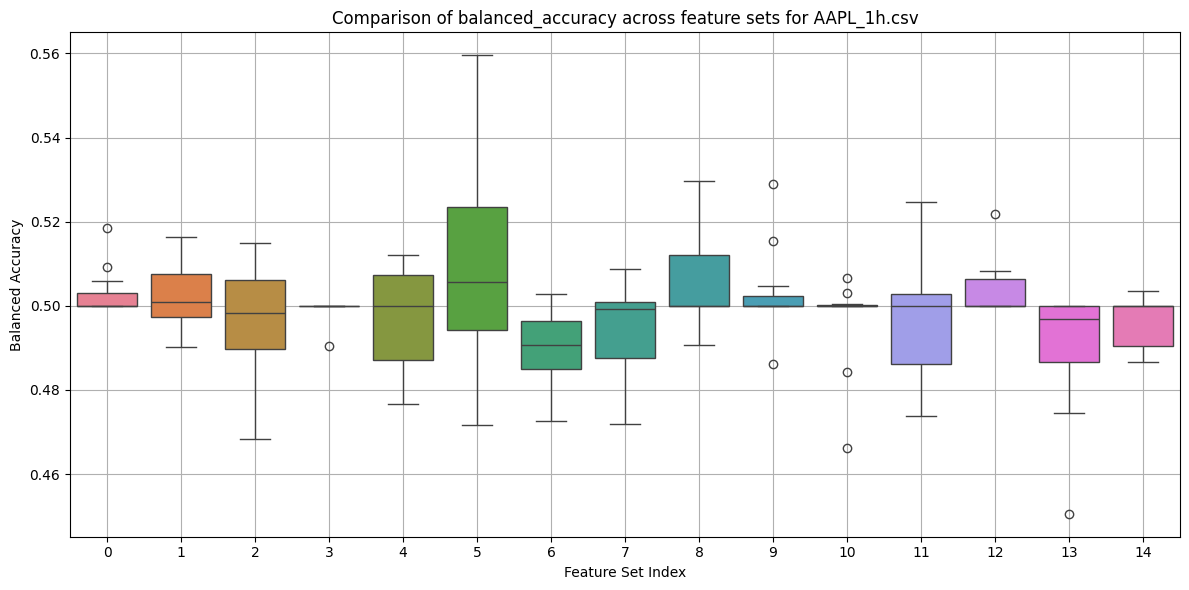

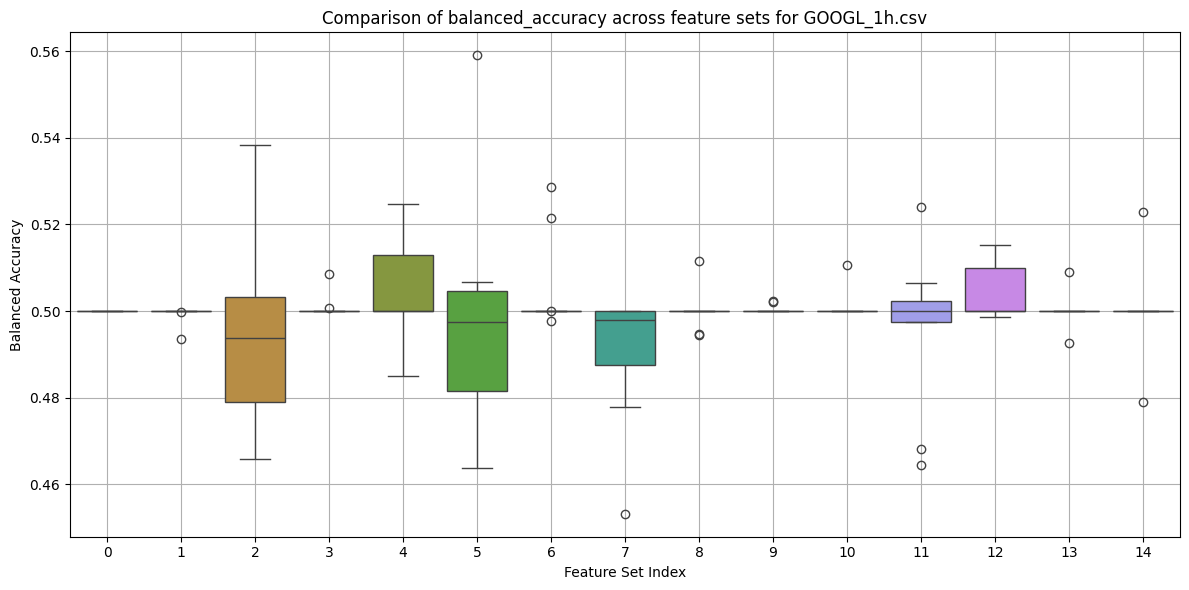

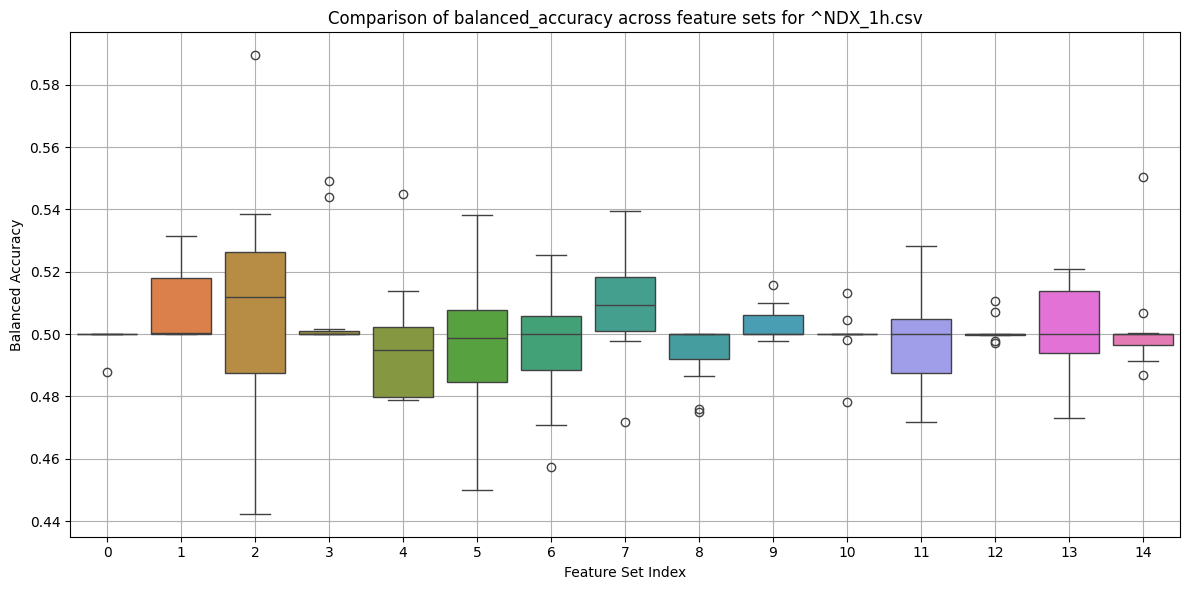

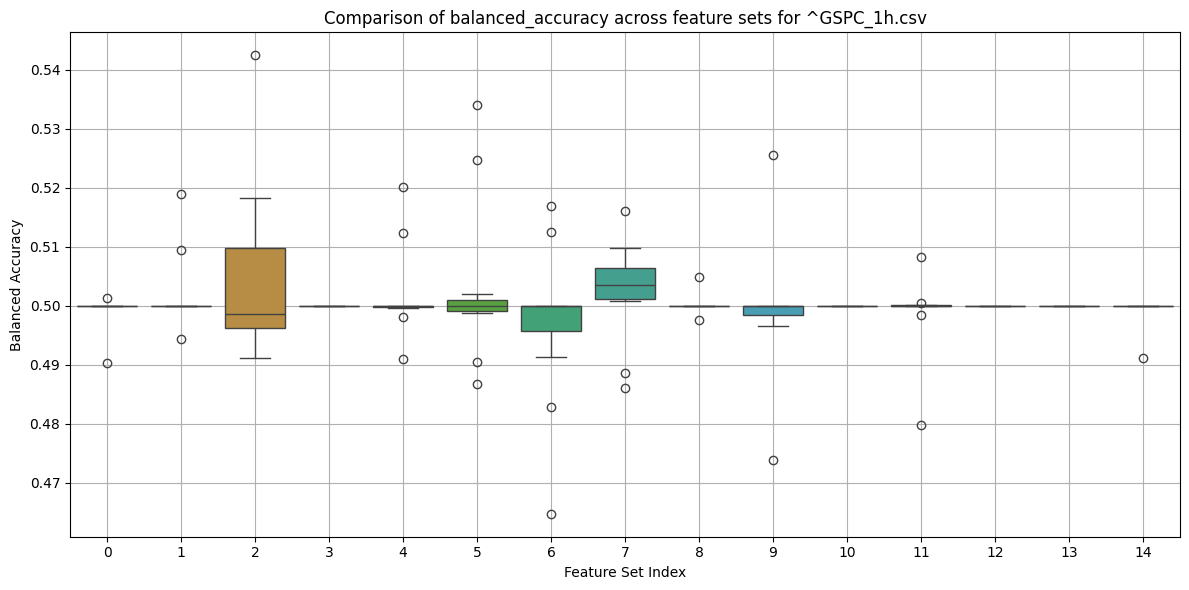

In [4]:
metrics = ["balanced_accuracy"] # "f1_score" "balanced_accuracy"
files = df['file_path'].unique()
for file in files:
    file_name = file.split('/')[-1]
    df_file = df[df['file_path'] == file]
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(x='feature_set_index', y=metric, hue='features', data=df_file)
        plt.title(f'Comparison of {metric} across feature sets for {file_name}')
        plt.xlabel('Feature Set Index')
        plt.ylabel(metric.replace('_', ' ').title())
        # plt.legend(title='features')
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# AUC ROC PER INDEX

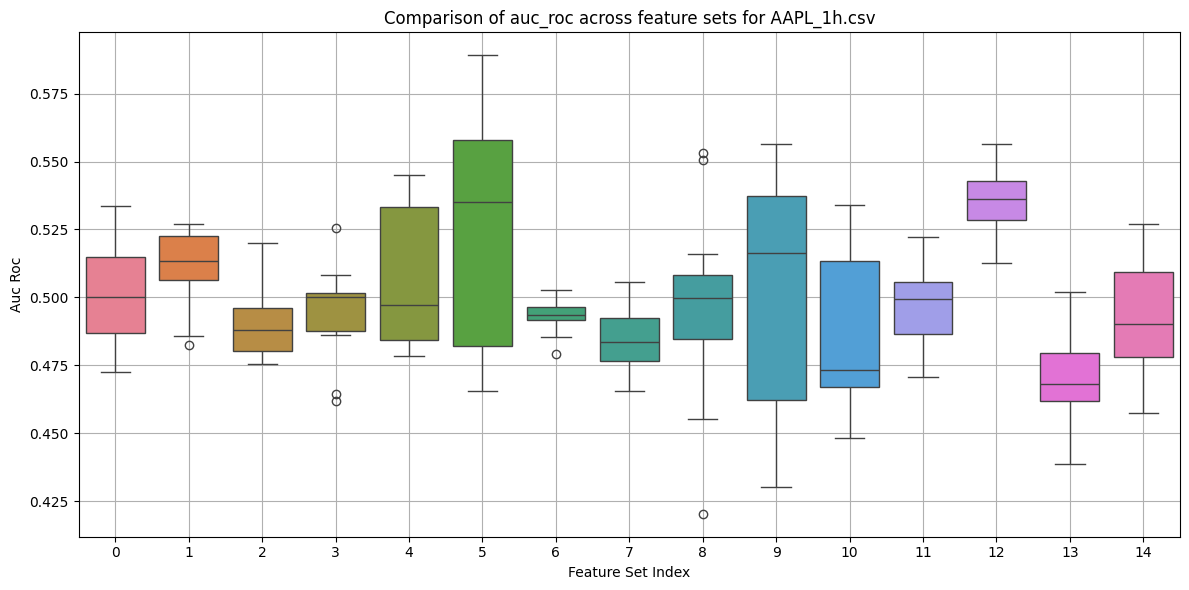

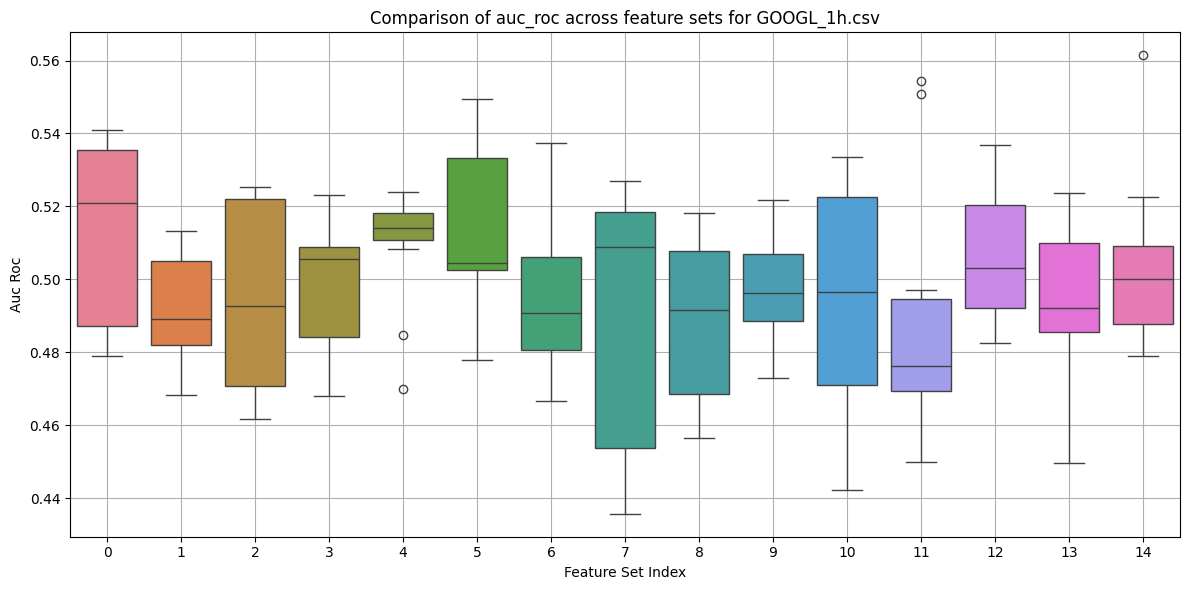

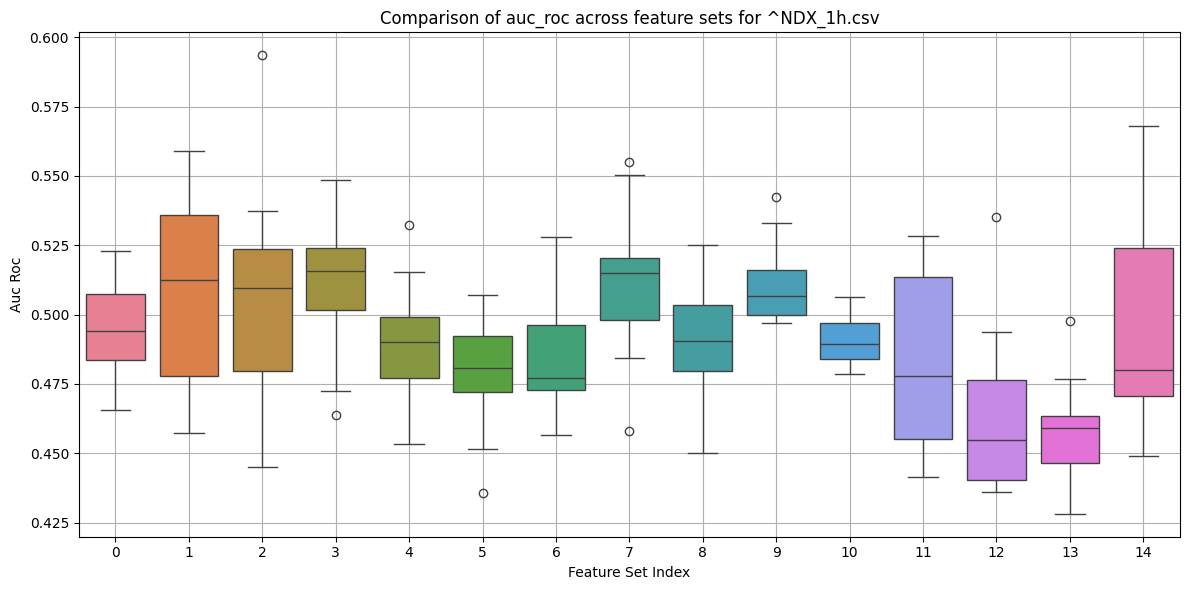

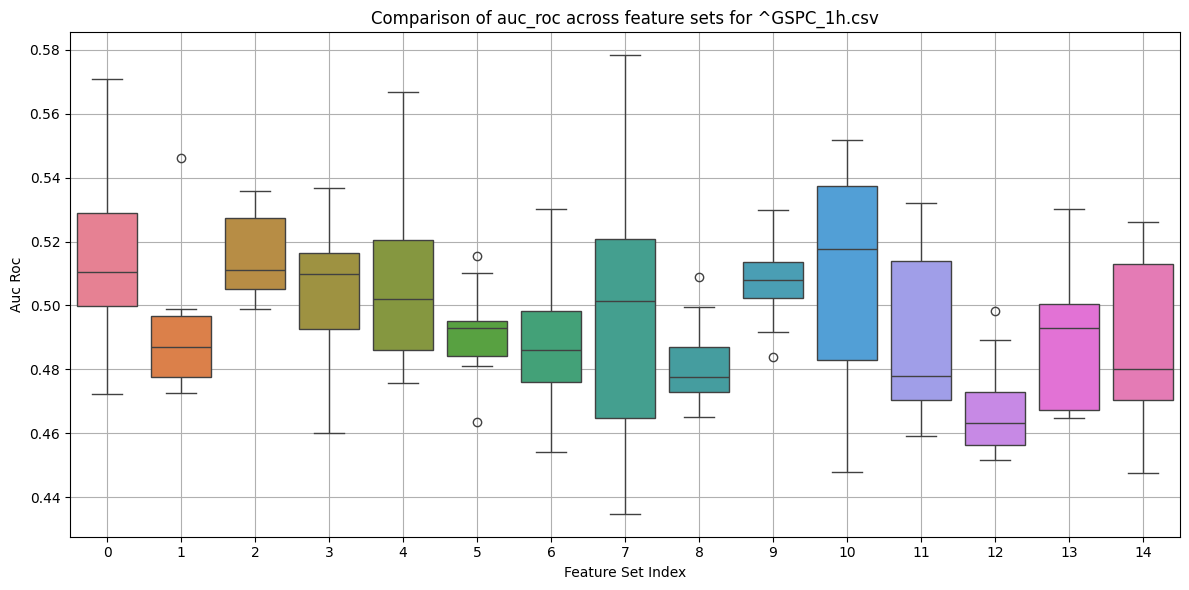

In [5]:
metrics = ["auc_roc"] # "f1_score" "balanced_accuracy"
files = df['file_path'].unique()
for file in files:
    file_name = file.split('/')[-1]
    df_file = df[df['file_path'] == file]
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(x='feature_set_index', y=metric, hue='features', data=df_file)
        plt.title(f'Comparison of {metric} across feature sets for {file_name}')
        plt.xlabel('Feature Set Index')
        plt.ylabel(metric.replace('_', ' ').title())
        # plt.legend(title='features')
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# SUMMARY ACCURACY AND AUC ROC PER INDEX

In [6]:
for file in files:
    file_name = file.split('/')[-1]
    df_file = df[df['file_path'] == file]
    df_grouped = df_file.groupby(['feature_set_index']).agg(
        median_auc_roc=('auc_roc', 'median'),
        median_accuracy=('accuracy', 'median'),
        avg_last_epoch_num=('last epoch num', 'mean'),
        features_col=('features', 'first'),
    ).sort_values(by='median_auc_roc', ascending=False).reset_index() 
    print(f'\nSummary for file: {file_name}')
    print(tb.tabulate(df_grouped, headers='keys', tablefmt='psql'))


Summary for file: AAPL_1h.csv
+----+---------------------+------------------+-------------------+----------------------+-------------------------------------------------------------------------------------------------------------------+
|    |   feature_set_index |   median_auc_roc |   median_accuracy |   avg_last_epoch_num | features_col                                                                                                      |
|----+---------------------+------------------+-------------------+----------------------+-------------------------------------------------------------------------------------------------------------------|
|  0 |                  12 |         0.53616  |          0.49848  |              21.0909 | ['Close', 'rsi_14', 'rsi_28', 'stoch_k', 'stoch_d', 'bb_upper_20', 'bb_middle_20', 'bb_lower_20', 'atr_14']       |
|  1 |                   5 |         0.5352   |          0.504559 |              22.6364 | ['Close', 'roc']                                  

# RESULTS AGG

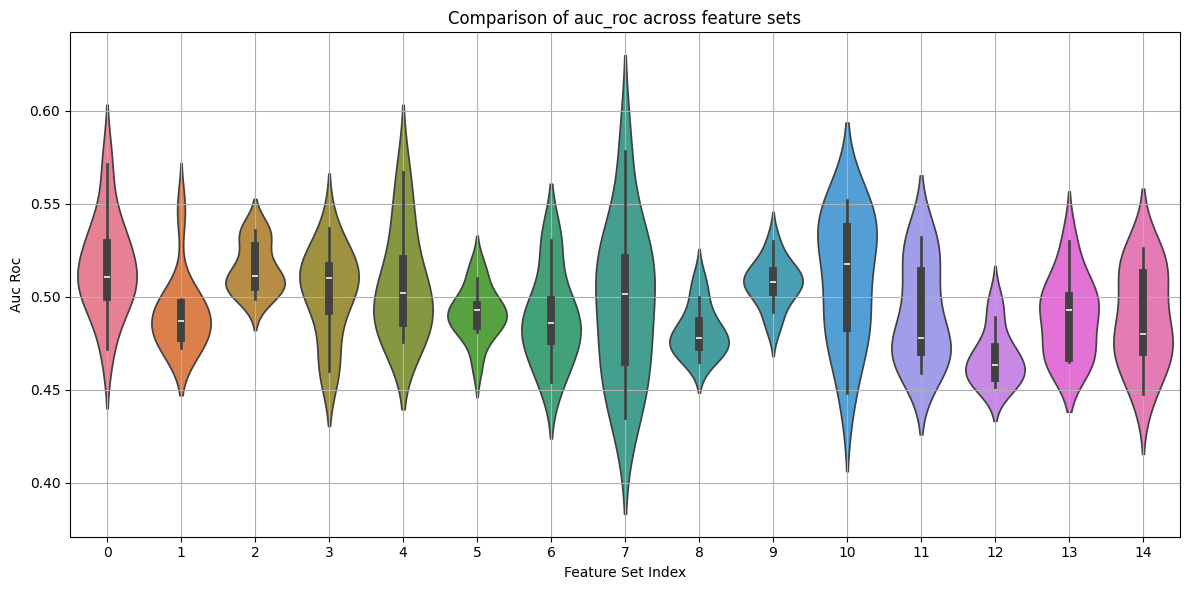

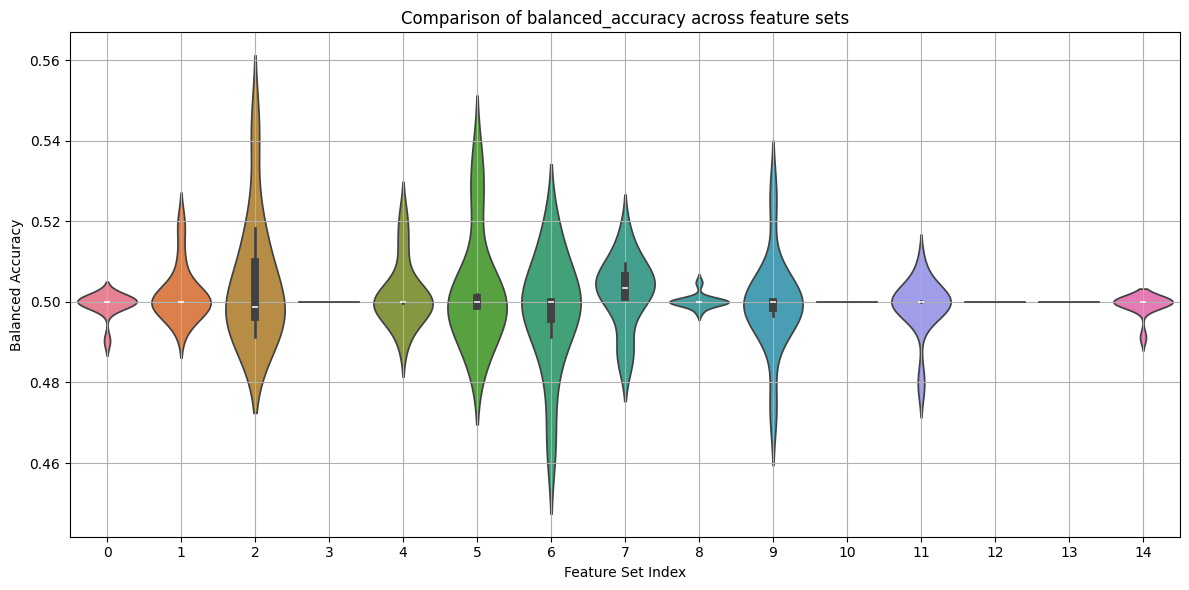

In [7]:
metrics = ["auc_roc", "balanced_accuracy"] # "f1_score" "balanced_accuracy"
for metric in metrics:
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='feature_set_index', y=metric, hue='features', data=df_file)
    plt.title(f'Comparison of {metric} across feature sets')
    plt.xlabel('Feature Set Index')
    plt.ylabel(metric.replace('_', ' ').title())
    # plt.legend(title='features')
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
#calc rankings for features sets by each file
df['auc_roc_rank'] = df.groupby('file_path')['auc_roc'].rank(ascending=False, method='min')
df['accuracy_rank'] = df.groupby('file_path')['accuracy'].rank(ascending=False,method='min')
df['combined_rank'] = df['auc_roc_rank'] + df['accuracy_rank']
df_ranked = df.groupby('feature_set_index').agg(
    median_combined_rank=('combined_rank', 'median'),
    median_auc_roc=('auc_roc', 'median'),
    median_accuracy=('accuracy', 'median'),
    features_col=('features', 'first'),
).sort_values(by='median_combined_rank').reset_index()

print('\nOverall Feature Set Rankings:')
print(tb.tabulate(df_ranked, headers='keys', tablefmt='psql'))


Overall Feature Set Rankings:
+----+---------------------+------------------------+------------------+-------------------+-------------------------------------------------------------------------------------------------------------------+
|    |   feature_set_index |   median_combined_rank |   median_auc_roc |   median_accuracy | features_col                                                                                                      |
|----+---------------------+------------------------+------------------+-------------------+-------------------------------------------------------------------------------------------------------------------|
|  0 |                   0 |                   97.5 |         0.503104 |          0.515198 | ['Close']                                                                                                         |
|  1 |                   9 |                  102   |         0.506172 |          0.507599 | ['Close', 'body_range_ratio']           

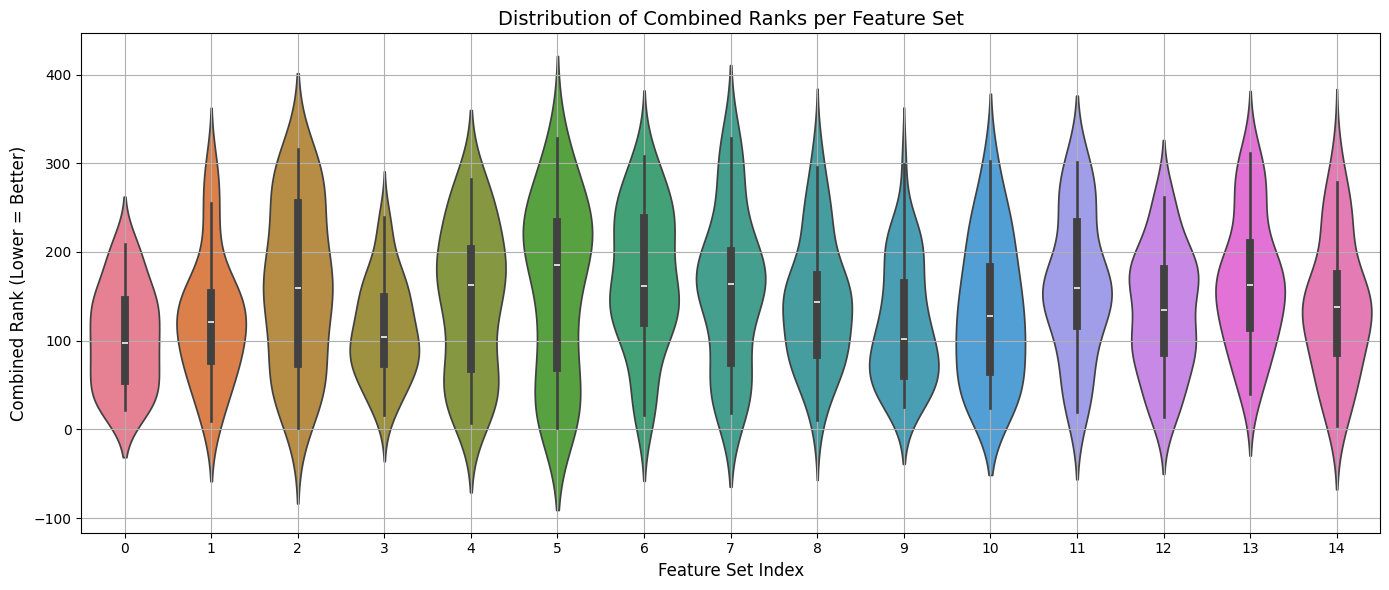

+----+---------------------+-------------------------------------------------------------------------------------------------------------------+
|    |   feature_set_index | features                                                                                                          |
|----+---------------------+-------------------------------------------------------------------------------------------------------------------|
|  0 |                   0 | ['Close']                                                                                                         |
|  1 |                   1 | ['Close', 'rsi_14', 'rsi_28', 'rsi_50', 'rsi_7']                                                                  |
|  2 |                   2 | ['Close', 'macd']                                                                                                 |
|  3 |                   3 | ['Close', 'ema_10', 'ema_20', 'ema_50', 'ema_100', 'ema_200']                                        

In [9]:
plt.figure(figsize=(14, 6))
ax = sns.violinplot(x='feature_set_index', y='combined_rank', hue='features', data=df)


plt.title("Distribution of Combined Ranks per Feature Set", fontsize=14)
plt.xlabel("Feature Set Index", fontsize=12)
plt.ylabel("Combined Rank (Lower = Better)", fontsize=12)
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.tight_layout()
plt.grid(True)
plt.show()

print(tb.tabulate(df[['feature_set_index', 'features']].drop_duplicates().sort_values('feature_set_index'), headers='keys', tablefmt='psql'))